# 🏗️ Titanic Project

## 1. Introduction & Objectives

* Goal: Predict passenger survival (Binary Classification).

* Metric: Accuracy and Confusion Matrix.

* survival	-->        Survival	        0 = No, 1 = Yes
* pclass	-->        Ticket class	        1 = 1st, 2 = 2nd, 3 = 3rd
* sex	   -->     Sex	
* Age	  -->      Age in years	
* sibsp	   -->     # of siblings / spouses aboard the Titanic	
* parch	   -->     # of parents / children aboard the Titanic	
* ticket	-->        Ticket number	
* fare	    -->    Passenger fare	
* cabin	    -->    Cabin number	
* embarked	    -->    Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
##  2. Environment Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline & Modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Load Data
df_before_cleaning = pd.read_csv('data/train.csv')
df = df_before_cleaning
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3. Data Wrangling

* Cleaning, deduplication, handling missing values.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [5]:
df.duplicated().sum()

0

No Duplicate Rows

In [6]:
df.set_index('PassengerId', inplace=True)

PassengerId is the index of each record

In [7]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

Imbalanced (Not Survived Favoured)

#### Gender Analysis on Survival

In [9]:
df['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [10]:
female_count = df.loc[df['Sex']=='female' , 'Survived'].count()
female_suvive = df.loc[(df['Sex']=='female') & (df['Survived']==1), 'Survived'].count()

print(f"Female Survived: {female_suvive} out of {female_count}")

Female Survived: 233 out of 314


In [11]:
male_count = df.loc[df['Sex']=='male' , 'Survived'].count()
male_suvive = df.loc[(df['Sex']=='male') & (df['Survived']==1), 'Survived'].count()

print(f"male Survived: {male_suvive} out of {male_count}")

male Survived: 109 out of 577


In [12]:
df.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

74% of females survived while only 19% of males survived

#### Handling missing values

In [13]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [14]:
df = df.drop('Cabin', axis=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Dropped Cabin column since too many missing values


In [15]:
average_age = df['Age'].mean().round()

df['Age'].replace(np.nan, average_age, inplace=True)

df.isnull().sum()

C:\Users\omarh\AppData\Local\Temp\ipykernel_74180\430338968.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].replace(np.nan, average_age, inplace=True)


Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    2
dtype: int64

Replaced Missing Age with Average Age

In [16]:
frequent_embarked = df['Embarked'].value_counts().idxmax()

df['Embarked'].replace(np.nan, frequent_embarked, inplace=True)

df.isnull().sum()

C:\Users\omarh\AppData\Local\Temp\ipykernel_74180\1241292062.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].replace(np.nan, frequent_embarked, inplace=True)


Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

Replaced missing emarked values with mode

#### Binning

In [17]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.758889,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002570,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [18]:
age_bins = [min(df['Age']),12,19,29,44,59, max(df['Age'])]
age_labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Middle Aged', 'Senior']

df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=True)

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_Group
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Young Adult
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Young Adult
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Adult
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Adult


Binned age based on **'Child', 'Teen', 'Young Adult', 'Adult', 'Middle Aged', 'Senior'** labels

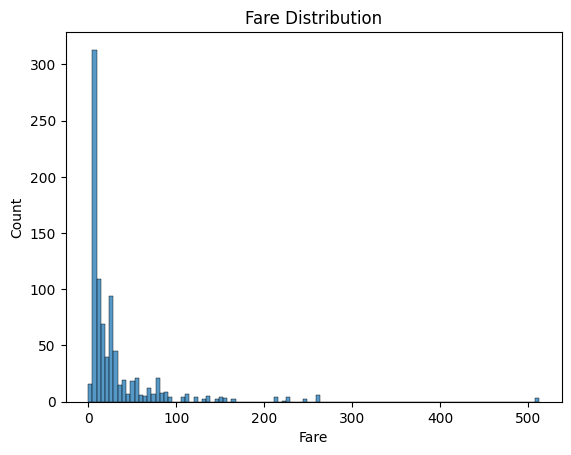

In [19]:
sns.histplot(df, x='Fare')
plt.title('Fare Distribution')
plt.show()

In [20]:
df = df.drop('Age', axis=1)
df.head()

,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked,Age_Group
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,S,Young Adult
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C,Adult
3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,S,Young Adult
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,S,Adult
5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,S,Adult


In [21]:
df_before_cleaning.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Check data type

In [22]:
df.dtypes

Survived        int64
Pclass          int64
Name           object
Sex            object
SibSp           int64
Parch           int64
Ticket         object
Fare          float64
Embarked       object
Age_Group    category
dtype: object

* Age_Group, Sex and Embarked are categories
* SibSp ,Parch and Fare are numbers
* Pclass is already encoded category
* Name and ticket are neither

## 4. EDA & Visualization

* Pattern discovery, trend analysis, visual inspections.

## 5. ML Pipeline
* Scaling, encoding categorical variables, model pipelines.


## 6. Model Evaluation
* Assess performance (Accuracy , Confusion Matrix and F1-score)